# Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19

## Цель проекта

Разработать аналитическую систему для эпидемиологического мониторинга COVID-19 на основе метаданных рентгеновских снимков, используя стек PySpark

## Выполнение проекта

### 1. Подготовка среды

#### Настроить рабочее окружение с PySpark (локально или в Google Colab)

In [3]:
!java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)


In [4]:
!python --version

Python 3.12.12


In [107]:
# Формирование файла зависимостей
%%writefile requirements.txt
pyspark==3.5.1
pandas
matplotlib
seaborn
datetime

Overwriting requirements.txt


In [6]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=20b63de35af1590bbc1ad728a52b347d89875a0f4b0219cf626a5cfabf439572
  Stored in directory: /root/.cache/pip/wheels/b1/91/5f/283b53010a8016a4ff1c4a1edd99bbe73afacb099645b5471b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-conn

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, mean, percentile_approx
from pyspark.sql.functions import row_number, first, rand, trim, coalesce, to_date, max, lit, month
from pyspark.sql.functions import regexp_replace, when, concat, length, unix_timestamp, lower, year, udf
from pyspark.sql import Row
from pyspark.sql import Window
from pyspark.sql.types import StringType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#### Убедиться, что Spark-сессия корректно запускается

In [8]:
spark = SparkSession.builder \
    .appName("COVID19_analysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

In [9]:
spark.version

'3.5.1'

In [10]:
spark.sparkContext

<SparkContext master=local[*] appName=COVID19_analysis>

#### Проверить работу базовых операций с данными

In [11]:
!wget "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv" -O /tmp/metadata.csv

--2025-12-24 18:54:32--  https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599143 (585K) [text/plain]
Saving to: ‘/tmp/metadata.csv’

/tmp/metadata.csv   100%[===================>] 585.10K  --.-KB/s    in 0.05s   

2025-12-24 18:54:32 (11.7 MB/s) - ‘/tmp/metadata.csv’ saved [599143/599143]



In [12]:
df_raw = spark.read.csv("/tmp/metadata.csv", header=True, inferSchema=True)

In [13]:
# Проверим работу базовых операций с данными
df_raw.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

In [14]:
df_raw.show()

+---------+------+----+----+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+--------+--------------------+-----------+----+
|patientid|offset| sex| age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url| license|      clinical_notes|other_notes|_c29|
+---------+------+----+----+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+-------

Данный датасет является побочным по отношению к исходному датасету с изображениями снимков больных. Поэтому каждая строка - это метаданные к этим изображениям (изображения могут быть уникальны, метаданные - нет, например, первые 4 записи, похоже, абсолютно идентичны и относятся к одному пациенту)

In [15]:
# Общее кол-во записей
df_raw.count()

950

In [16]:
# Проверим как выглядят требуемые по заданию параметры
df_raw.select("patientid", "age", "sex", "finding", "view", "date").show()

+---------+----+----+--------------------+----+----------------+
|patientid| age| sex|             finding|view|            date|
+---------+----+----+--------------------+----+----------------+
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 22, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 27, 2020|
|        2|  65|   M|Pneumonia/Viral/C...|  PA|January 28, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 25, 2020|
|        4|  52|   F|Pneumonia/Viral/C...|  PA|January 30, 2020|
|        5|NULL|NULL|           Pneumonia|  PA|            2017|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA| January 6, 2020|
|        6|NULL|NULL|Pneumonia/Viral/C...|  PA|January 10, 2020|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        3|  74|   M|Pneumonia/Viral/SARS|  AP|            2004|
|        7|  29|   F|Pneu

Видим, что в данных есть пропуски

### 2. Предобработка данных (Очистка метаданных)

In [17]:
# Сразу отбросим все ненужные параметры
df = df_raw.select("patientid", "age", "sex", "finding", "view", "date")

# Выведем на экран структуру
df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)



#### Унифицировать диагнозы

In [18]:
# Посмотрим, какие есть уникальные диагнозы
df.select("finding").distinct().show(50, truncate=False)

+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Aspiration                   |
|Pneumonia/Lipoid                       |
|Tuberculosis                           |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial                    |
|Pneumonia/Viral/MERS-CoV               |
|Unknown                                |
|Pneumonia/Viral/Varicella              |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Bacterial/Nocardia           |
|todo                                   |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Fungal/Aspergillosis         |
|Pneumonia/Viral/Herpes           

In [19]:
# Унифицируем диагнозы
df = df.withColumn(
    "finding_uni", lower(trim("finding"))
).withColumn(
    "finding",
    when(col("finding_uni") == "tuberculosis", "tuberculosis")
    .when(col("finding_uni") == "no finding", "no_finding")
    .when(col("finding_uni").isin("unknown", "todo"), "unknown")
    .when(col("finding_uni").like("pneumonia/bacterial%"), "pneumonia_bacterial")
    .when(col("finding_uni") == "pneumonia/viral/covid-19", "covid19")
    .when(col("finding_uni").like("pneumonia/viral/%"), "pneumonia_viral")
    .when(col("finding_uni").like("pneumonia/fungal%"), "pneumonia_fungal")
    .when(col("finding_uni").isin("pneumonia/aspiration", "pneumonia/lipoid", "pneumonia"), "pneumonia_non-infectious")
    .otherwise("other")
).drop("finding_uni")

In [20]:
df.select("finding").distinct().show(50, truncate=False)

+------------------------+
|finding                 |
+------------------------+
|pneumonia_viral         |
|no_finding              |
|unknown                 |
|pneumonia_non-infectious|
|pneumonia_bacterial     |
|covid19                 |
|tuberculosis            |
|pneumonia_fungal        |
+------------------------+



#### Заполнить пропуски в данных

In [21]:
missing_data = df.select([
    (count(when(col(c).isNull(), c)) / df.count()).alias(c)
    for c in df.columns
]).toPandas()

missing_data.T

,0
patientid,0.000000
age,0.249474
sex,0.084211
finding,0.000000
view,0.000000
date,0.304211


Видим, что в 3 столбцах пропусков нет, но в других количество колеблется от 8 до 30%, что существенно

Тем более с учётом объема датасета (950 наблюдений) и их явного дублирования

Заполним пропуски по следующей логике:
- пол и возраст обычно морбидоспецифичны (зависимость болезни от половозрастных и прочих факторов - термин буквально выдумал, не уверен, что такой существует), заполним пропуски в них медианным значением по аналогичному диагнозу ('findings')
- в случае отсутствия пола, возраста и диагноза в строке без даты - удалим её


In [22]:
median_age = df.approxQuantile("age", [0.5], 0.01)[0]
median_age

54.0

In [23]:
age_medians = df.groupBy("finding").agg(
    percentile_approx("age", 0.5).alias("median_age")
)

age_medians.show()

+--------------------+----------+
|             finding|median_age|
+--------------------+----------+
|     pneumonia_viral|        46|
|          no_finding|        47|
|             unknown|      NULL|
|pneumonia_non-inf...|        53|
| pneumonia_bacterial|        50|
|             covid19|        58|
|        tuberculosis|        40|
|    pneumonia_fungal|        34|
+--------------------+----------+



In [24]:
# Прикрепляем к исходному DataFrame
df_filled = df.join(age_medians, "finding", "left")

In [25]:
# Заполняем пропуски в возрасте
df_filled = df_filled.withColumn("age_filled",
                                 when(col("age").isNull(),
                                      col("median_age")).otherwise(col("age")))

In [26]:
# Считаем количество записей по полу и диагнозу
sex_counts = df_filled.filter(col("sex").isNotNull())\
    .groupBy("finding", "sex").count()

sex_counts.show()

+--------------------+---+-----+
|             finding|sex|count|
+--------------------+---+-----+
| pneumonia_bacterial|  M|   48|
|    pneumonia_fungal|  F|    4|
|        tuberculosis|  F|    5|
|pneumonia_non-inf...|  F|   52|
|        tuberculosis|  M|   13|
|     pneumonia_viral|  M|   14|
|pneumonia_non-inf...|  M|   42|
|             unknown|  F|   23|
|          no_finding|  M|   11|
|             unknown|  M|   60|
|     pneumonia_viral|  F|   18|
|    pneumonia_fungal|  M|   25|
|             covid19|  M|  346|
|             covid19|  F|  175|
|          no_finding|  F|   10|
| pneumonia_bacterial|  F|   24|
+--------------------+---+-----+



Отмечаем, что большинство случаев диагностируются как covid и среди заболевших - больше мужчин

In [27]:
# Создаем окно для ранжирования по количеству в каждой группе диагнозов
window = Window.partitionBy("finding").orderBy(col("count").desc())

In [28]:
# Присваиваем ранги и берем самый частый пол для каждого диагноза
sex_mode_by_finding = sex_counts.withColumn("rank", row_number().over(window))\
    .filter(col("rank") == 1)\
    .select(col("finding"), col("sex").alias("mode_sex"))

sex_mode_by_finding.show()

+--------------------+--------+
|             finding|mode_sex|
+--------------------+--------+
|             covid19|       M|
|          no_finding|       M|
| pneumonia_bacterial|       M|
|    pneumonia_fungal|       M|
|pneumonia_non-inf...|       F|
|     pneumonia_viral|       F|
|        tuberculosis|       M|
|             unknown|       M|
+--------------------+--------+



In [29]:
# Прикрепляем к исходному DataFrame
df_filled = df_filled.join(sex_mode_by_finding, "finding", "left")

In [30]:
# Заполняем пропуски
df_filled = df_filled.withColumn("sex_filled",
    when(col("sex").isNull(), col("mode_sex")).otherwise(col("sex")))

In [31]:
# Восстанавливаем исходный порядок столбцов
df_filled = df_filled.select(
    col("patientid"),
    col("age_filled").alias("age"),
    col("sex_filled").alias("sex"),
    col("finding"),
    col("view"),
    col("date")
)

In [32]:
df_filled.count()

950

In [33]:
# Полностью удаляем записи, в которых пропущен age, sex и диагноз
df_filled = df_filled.filter(
    col("age").isNotNull() &
    col("sex").isNotNull() &
    (col("finding") != "unknown")
)

In [34]:
print(f'Удалено {950 - df_filled.count()} записи')

Удалено 84 записи


Проверяем оставшиеся пропуски

In [35]:
df_filled.filter(col("age").isNull()).show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
+---------+---+---+-------+----+----+



In [36]:
df_filled.filter(col("sex").isNull()).show()

+---------+---+---+-------+----+----+
|patientid|age|sex|finding|view|date|
+---------+---+---+-------+----+----+
+---------+---+---+-------+----+----+



In [37]:
# Проверяем пропуски в дате
missing_dates = df_filled.filter(col("date").isNull()).count()
missing_dates

288

In [38]:
# Смотрим, какие есть разновидности заполнения данных в date
df_filled.where(col('date').isNotNull()).groupBy('date').count().orderBy(col('count').desc()).show(100, 0)

+------------------+-----+
|date              |count|
+------------------+-----+
|2020              |371  |
|2015              |24   |
|2016              |20   |
|2014              |11   |
|2004              |11   |
|2013              |7    |
|2018              |6    |
|Mar 4, 2020       |6    |
|February 6, 2020  |6    |
|March 10, 2020    |5    |
|2011              |5    |
|March 2003        |5    |
|Mar 3, 2020       |5    |
|March 5, 2020     |4    |
|January 22, 2020  |4    |
|2017              |3    |
|March 4, 2020     |3    |
|January 27, 2020  |3    |
|January 25, 2020  |3    |
|2010              |3    |
|2/29/2020         |2    |
|2019              |2    |
|December 29, 2019 |2    |
|May 4, 2010       |2    |
|January 1, 2020   |2    |
|January 26, 2020  |2    |
|Feb 21, 2020      |2    |
|03/16/20          |2    |
|January 19, 2020  |2    |
|January 31, 2020  |2    |
|11/27/19          |2    |
|March 7, 2020     |2    |
|03/09/20          |2    |
|March 2020        |2    |
|

In [39]:
df_filled.where((col("finding") == "covid19") & col('date').isNotNull()) .groupBy('date').count().orderBy(col('count').desc()).first()[0]

'2020'

Просто брать медиану по диагнозу не получится, т.к. самое частое значение - просто "2020"

In [40]:
# Сначала отфильтруем только те записи, где дата содержит месяц и день
# (используем регулярное выражение для поиска букв в дате - это указывает на наличие месяца)
covid_full_dates = df_filled.filter(
    (col("finding") == "covid19") &
    (col("date").isNotNull()) &
    # Ищем записи, где есть буквы (месяц) или слэши (формат MM/dd/yyyy)
    (col("date").rlike("[A-Za-z/]"))
)

covid_full_dates.count()

91

Значений для covid19 немного, но лучше, чем ничего

In [41]:
# Преобразуем эти даты в корректный формат
covid_full_dates = covid_full_dates.withColumn("parsed_date",
    coalesce(
        to_date(col("date"), "MMMM dd, yyyy"),
        to_date(col("date"), "MMM dd, yyyy"),
        to_date(col("date"), "dd/MM/yy"),
        to_date(col("date"), "dd/MM/yyyy"),
        to_date(col("date"), "MM/dd/yyyy"),
        to_date(regexp_replace(col("date"), "([A-Za-z]+) (\\d{4})", "$1 01, $2"), "MMMM dd, yyyy"),
        to_date(concat(col("date"), lit(" 2020")), "MMMM dd yyyy"),
        to_date(col("date"))
    )
)

In [42]:
covid_full_dates = covid_full_dates.filter(col("parsed_date").isNotNull())

In [43]:
most_common_date = covid_full_dates.groupBy("parsed_date").count()\
    .orderBy(col("count").desc())\
    .first()["parsed_date"]

most_common_date

datetime.date(2020, 3, 4)

Видим, что подбор по медианной дате корректнее: если просто заменить 2020 на 01.01.2020, то разница составит несколько месяцев. Дата 04.03.2020 кажется логичнее, именно тогда начались существенные ковидные ограничения, связанные с резким ростом числа заболевших. Логично предположить, что снимки поступающих больных также делались в это время

Переходим к преобразованию форматов, включая "только год" (таких больше всего)

In [44]:
# Преобразуем основные форматы даты
# Создаем несколько попыток преобразования разных форматов
df_filled = df_filled.withColumn("date_clean",
    coalesce(
        # Полный формат: "January 22, 2020"
        to_date(col("date"), "MMMM dd, yyyy"),
        # Короткий формат: "Jan 22, 2020"
        to_date(col("date"), "MMM dd, yyyy"),
        # Короткий американский формат: "01/22/20"
        to_date(col("date"), "MM/dd/yy"),
        # Американский формат: "01/22/2020"
        to_date(col("date"), "MM/dd/yyyy"),
        # Европейский формат: "22/01/2020"
        to_date(col("date"), "dd/MM/yyyy"),
        # Формат с месяцем словом: "March 2020"
        to_date(regexp_replace(col("date"), "([A-Za-z]+) (\\d{4})", "$1 01, $2"), "MMMM dd, yyyy"),
        # Только год: "2020"
        to_date(concat(col("date"), lit("-01-01")), "yyyy-MM-dd"),
        # Только дата: "MMMM DD"
        to_date(concat(col("date"), lit(" 2020")), "MMMM dd yyyy"),
        # Стандартный формат
        to_date(col("date"))
    )
)

In [45]:
# Используем найденную наиболее частую дату для заполнения пропусков (если диагноз - covid19)
df_final = df_filled.withColumn("date_clean",
    when(col("date_clean").isNull() & (col("finding") == "covid19"), lit(most_common_date))
    .otherwise(col("date_clean"))
)

In [46]:
# Для оставшихся пропусков (не covid19) используем глобальную медианную дату
non_covid_dates = df_final.filter(
    col("date_clean").isNotNull() &
    (col("finding") != "covid19")
)

In [47]:
if non_covid_dates.count() > 0:
    # Используем Unix timestamp для вычисления медианы
    non_covid_dates = non_covid_dates.withColumn("date_unix", unix_timestamp(col("date_clean")))
    median_unix = non_covid_dates.approxQuantile("date_unix", [0.5], 0.01)[0]
    global_median_date = datetime.datetime.fromtimestamp(median_unix).date()

    df_final = df_final.withColumn("date_clean",
        when(col("date_clean").isNull(), lit(global_median_date))
        .otherwise(col("date_clean"))
)

In [48]:
# Проверим, как выглядит распределение лет теперь
df_final.groupBy(year(col("date_clean")).alias("year")).count()\
    .orderBy(col("year"))\
    .show()

+----+-----+
|year|count|
+----+-----+
|2003|    5|
|2004|   11|
|2007|    1|
|2009|    3|
|2010|    6|
|2011|    5|
|2013|    7|
|2014|   11|
|2015|  185|
|2016|   20|
|2017|    4|
|2018|    6|
|2019|   10|
|2020|  592|
+----+-----+



In [49]:
# Удаляем старый столбец date
df_final = df_final.drop("date")
# Переименовываем date_clean в date
df_final = df_final.withColumnRenamed("date_clean", "date")

#### Удалить дубликаты

In [50]:
n_obs_init = df_final.count()
df_final = df_final.drop_duplicates()
n_obs_fin = df_final.count()
n_dublicates = n_obs_init - n_obs_fin
print(f"Удалено дубликатов: {n_dublicates}")


Удалено дубликатов: 227


### 3. Анализ качества данных

#### Построить распределение пропущенных значений по всем полям


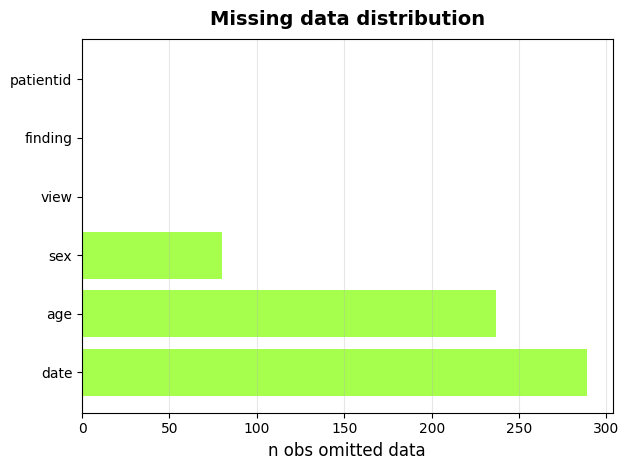

In [106]:
# Так как пропуски уже убраны, анализируем данные исходного датасета
missing_data_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])

# Преобразуем в pandas для визуализации
df_missing = missing_data_counts.toPandas().transpose()
df_missing.columns = ['missing_count']
total_rows = df.count()
df_missing['percentage'] = (df_missing['missing_count'] / total_rows) * 100
df_missing = df_missing.sort_values('missing_count', ascending=True)

# график
bars = plt.barh(df_missing.index, df_missing['missing_count'], alpha=0.7, color='chartreuse')
plt.gca().invert_yaxis()

plt.xlabel('n obs omitted data', fontsize=12)
plt.title('Missing data distribution', fontsize=14, fontweight='bold', pad=10)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### Выявить и обработать аномальные значения

Проверим как выглядят уникальные значения в категориальных переменных

In [52]:
# Распределение пола в sex
df_final.groupBy('sex').count().orderBy(col('count').desc()).show()

+---+-----+
|sex|count|
+---+-----+
|  M|  429|
|  F|  210|
+---+-----+



In [53]:
# Распределение проекций в view
df_final.groupBy('view').count().orderBy(col('count').desc()).show()

+---------+-----+
|     view|count|
+---------+-----+
|       PA|  251|
|       AP|  147|
|AP Supine|  111|
|        L|   70|
|    Axial|   47|
|  Coronal|   12|
| AP Erect|    1|
+---------+-----+



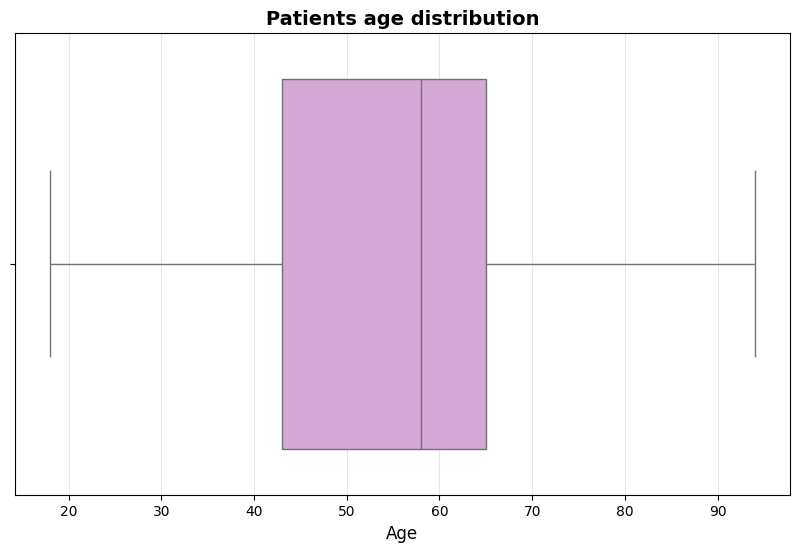

In [92]:
# Преобразуем в Pandas для визуализации
age_data = df_final.select("age").toPandas()

# Визуализация распределения возраста
plt.figure(figsize=(10, 6))
sns.boxplot(x=age_data['age'], color='plum')
plt.title('Patients age distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show()

In [55]:
print(f"Минимум: {age_data['age'].min()}")
print(f"Максимум: {age_data['age'].max()}")

Минимум: 18
Максимум: 94


Данные по возрасту реалистичны, аномалий нет

In [56]:
# Снова построим таблицу распределений по годам
# Ранжируем теперь по количеству наблюдений
df_final.groupBy(year(col("date")).alias("year")).count()\
    .orderBy(col("count").desc())\
    .show()

+----+-----+
|year|count|
+----+-----+
|2020|  444|
|2015|  133|
|2016|   14|
|2019|    9|
|2014|    6|
|2010|    6|
|2013|    5|
|2004|    5|
|2017|    4|
|2003|    3|
|2018|    3|
|2009|    3|
|2011|    3|
|2007|    1|
+----+-----+



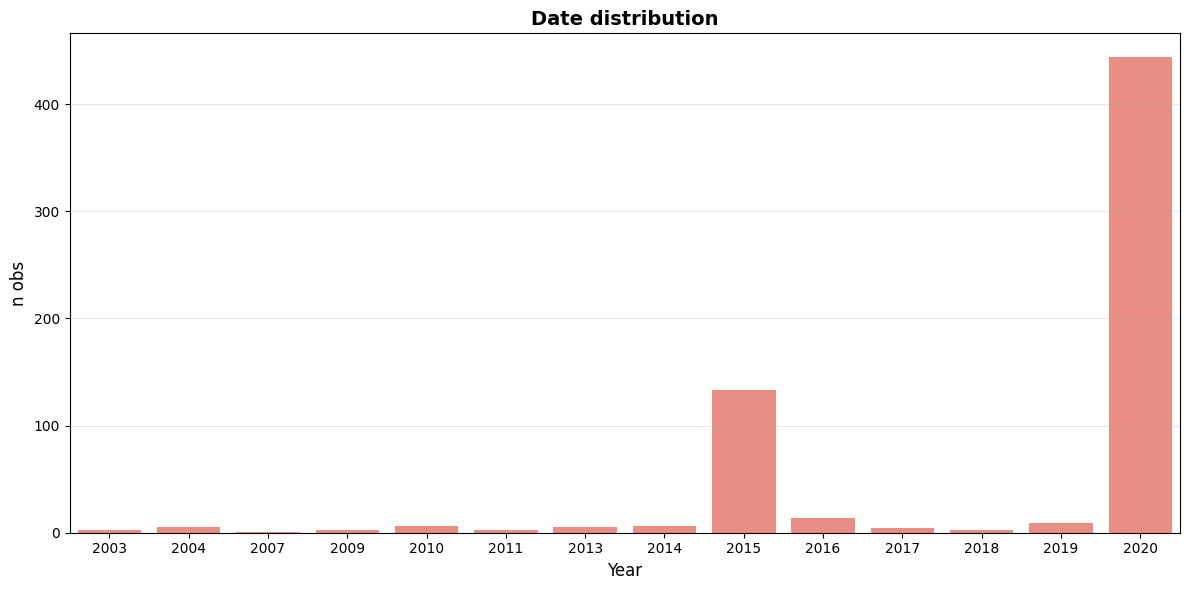

In [94]:
# Визуализация распределения по годам
year_data = df_final.groupBy(year(col("date")).alias("year")).count().toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='count', data=year_data.sort_values('year'), color='salmon')
plt.title('Date distribution', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('n obs', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Основная часть наблюдений - 2015 и 2020 гг

Явные аномалии также отсутствуют

#### Задокументировать обнаруженные проблемы данных

Согласно заданию, исследовался ограниченный пул переменных "patientid", "age", "sex", "finding", "view", "date", а не весь датасет

В этой ограниченной версии датасета выявлены следующие проблемы:
- Значимое количество пропусков
  - в переменной 'age' (24.95%)
  - в переменной 'sex' (8.42%)
  - в переменной 'date' (30.42%)
- Отсутствие унификации значений в переменной 'date'
- Значимое количество дубликатов (227/950~23.89%)

Пропуски обработаны следующим образом:
1. определение модального диагноза для каждой группы/значения внутри переменной
2. для 'age': заполнение пропусков медианным значением 'age' среди значений аналогичного диагноза
3. для 'sex': заполнение пропусков модальным значением 'sex' среди значений аналогичного диагноза
4. в случае наличия пропуска во всех трех столбцах ('age', 'sex' и 'findings'), наблюдение удалялось (но таких не было)
5. для 'date': заполнение пропусков модальным значением 'date' среди значений аналогичного диагноза, если это - covid19, и заполнение глобальной модой для всех остальных

После данной обработки исходный датасет сократился только на 24% (кол-во дубликатов), анализ аномалий показал их отсутствие

### 4. SQL-аналитика

In [58]:
# Регистрируем финальный DataFrame как временную SQL-таблицу
df_final.createOrReplaceTempView("covid_metadata")

#### Запрос 1. Базовая статистика по диагнозам

In [59]:
spark.sql("""
SELECT
    finding AS diagnosis,
    COUNT(*) AS total_cases_n,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS total_cases_pct,
    MIN(age) AS min_age,
    MAX(age) AS max_age
FROM covid_metadata
GROUP BY finding
ORDER BY total_cases_n DESC
""").show(truncate=False)

+------------------------+-------------+---------------+-------+-------+
|diagnosis               |total_cases_n|total_cases_pct|min_age|max_age|
+------------------------+-------------+---------------+-------+-------+
|covid19                 |437          |68.39          |20     |94     |
|pneumonia_non-infectious|70           |10.95          |18     |90     |
|pneumonia_bacterial     |42           |6.57           |25     |80     |
|pneumonia_viral         |27           |4.23           |23     |76     |
|pneumonia_fungal        |26           |4.07           |21     |70     |
|no_finding              |20           |3.13           |22     |78     |
|tuberculosis            |17           |2.66           |20     |78     |
+------------------------+-------------+---------------+-------+-------+



#### Запрос 2. Распределение по полу и диагнозам

In [60]:
spark.sql("""
SELECT
    finding AS diagnosis,
    COUNT(*) AS total_cases_n,
    SUM(CASE WHEN sex = 'M' THEN 1 ELSE 0 END) AS M_n,
    ROUND(SUM(CASE WHEN sex = 'M' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS M_pct,
    SUM(CASE WHEN sex = 'F' THEN 1 ELSE 0 END) AS F_n,
    ROUND(SUM(CASE WHEN sex = 'F' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS F_pct
FROM covid_metadata
GROUP BY finding
ORDER BY total_cases_n DESC
""").show(truncate=False)

+------------------------+-------------+---+-----+---+-----+
|diagnosis               |total_cases_n|M_n|M_pct|F_n|F_pct|
+------------------------+-------------+---+-----+---+-----+
|covid19                 |437          |308|70.48|129|29.52|
|pneumonia_non-infectious|70           |36 |51.43|34 |48.57|
|pneumonia_bacterial     |42           |28 |66.67|14 |33.33|
|pneumonia_viral         |27           |10 |37.04|17 |62.96|
|pneumonia_fungal        |26           |24 |92.31|2  |7.69 |
|no_finding              |20           |11 |55.00|9  |45.00|
|tuberculosis            |17           |12 |70.59|5  |29.41|
+------------------------+-------------+---+-----+---+-----+



#### Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов)

In [61]:
spark.sql("""
WITH ranked_patients AS (
    SELECT
        patientid,
        age,
        sex,
        finding AS diagnosis,
        ROW_NUMBER() OVER (
            PARTITION BY finding
            ORDER BY age DESC
        ) AS age_rank
    FROM covid_metadata
)
SELECT *
FROM ranked_patients
WHERE age_rank <= 3
ORDER BY diagnosis, age_rank
""").show(100, truncate=False)

+---------+---+---+------------------------+--------+
|patientid|age|sex|diagnosis               |age_rank|
+---------+---+---+------------------------+--------+
|326b     |94 |M  |covid19                 |1       |
|324b     |93 |F  |covid19                 |2       |
|200      |88 |M  |covid19                 |3       |
|315      |78 |F  |no_finding              |1       |
|325      |78 |F  |no_finding              |2       |
|313b     |75 |M  |no_finding              |3       |
|91       |80 |F  |pneumonia_bacterial     |1       |
|340      |80 |M  |pneumonia_bacterial     |2       |
|340      |80 |M  |pneumonia_bacterial     |3       |
|109      |70 |M  |pneumonia_fungal        |1       |
|109      |70 |M  |pneumonia_fungal        |2       |
|108      |50 |M  |pneumonia_fungal        |3       |
|460      |90 |M  |pneumonia_non-infectious|1       |
|460      |90 |M  |pneumonia_non-infectious|2       |
|454      |78 |F  |pneumonia_non-infectious|3       |
|172      |76 |M  |pneumonia

Видим, что в разрезе диагнозов самыми возрастными оказываются пожилые люди

Но в грибковой пневмонии и туберкулезе встречаются и относительно молодые пациенты (50, 58 лет)

Здесь также следует держать в уме, что исходная таблица была составлена по данным снимков и даже в укороченном виде она содержит столбцы 'view' (проекция снимка) и 'date' (дата снимка). Т.е. если для одного и того же пациента делалось несколько снимков (в разной проекции и/или в разные даты), то он повторится (и это не считается дубликатом)

In [62]:
# Если отбросить повторные записи пациентов
spark.sql("""
WITH unique_patients AS (
    -- Берем уникальных пациентов, выбирая самую раннюю запись для каждого
    SELECT *,
           ROW_NUMBER() OVER (
               PARTITION BY patientid
               ORDER BY date ASC
           ) AS patient_row_num
    FROM covid_metadata
),
ranked_patients AS (
    SELECT
        patientid,
        age,
        sex,
        finding AS diagnosis,
        ROW_NUMBER() OVER (
            PARTITION BY finding
            ORDER BY age DESC
        ) AS age_rank
    FROM unique_patients
    WHERE patient_row_num = 1  -- Берем только первую запись для каждого пациента
)
SELECT *
FROM ranked_patients
WHERE age_rank <= 3
ORDER BY diagnosis, age_rank
""").show(100, truncate=False)

+---------+---+---+------------------------+--------+
|patientid|age|sex|diagnosis               |age_rank|
+---------+---+---+------------------------+--------+
|326b     |94 |M  |covid19                 |1       |
|324b     |93 |F  |covid19                 |2       |
|200      |88 |M  |covid19                 |3       |
|325      |78 |F  |no_finding              |1       |
|313b     |75 |M  |no_finding              |2       |
|478      |75 |F  |no_finding              |3       |
|340      |80 |M  |pneumonia_bacterial     |1       |
|91       |80 |F  |pneumonia_bacterial     |2       |
|89       |75 |M  |pneumonia_bacterial     |3       |
|109      |70 |M  |pneumonia_fungal        |1       |
|106      |50 |M  |pneumonia_fungal        |2       |
|108      |50 |M  |pneumonia_fungal        |3       |
|460      |90 |M  |pneumonia_non-infectious|1       |
|454      |78 |F  |pneumonia_non-infectious|2       |
|283      |76 |M  |pneumonia_non-infectious|3       |
|172      |76 |M  |pneumonia

#### Запрос 4. Анализ временных трендов по датам исследований

In [63]:
spark.sql("""
SELECT
    YEAR(date) AS year,
    MONTH(date) AS month,
    COUNT(*) AS monthly_cases,
    ROUND(AVG(AGE), 1) AS avg_age
FROM covid_metadata
GROUP BY YEAR(date), MONTH(date)
ORDER BY year, month
""").show(30, truncate=False)

+----+-----+-------------+-------+
|year|month|monthly_cases|avg_age|
+----+-----+-------------+-------+
|2003|3    |3            |40.7   |
|2004|1    |5            |52.8   |
|2007|1    |1            |34.0   |
|2009|9    |3            |30.0   |
|2010|1    |3            |34.0   |
|2010|5    |2            |40.0   |
|2010|10   |1            |30.0   |
|2011|1    |3            |46.7   |
|2013|1    |5            |65.6   |
|2014|1    |6            |50.7   |
|2015|1    |132          |47.6   |
|2015|5    |1            |65.0   |
|2016|1    |14           |49.0   |
|2017|1    |3            |40.3   |
|2017|6    |1            |35.0   |
|2018|1    |3            |76.7   |
|2019|1    |2            |61.0   |
|2019|2    |1            |50.0   |
|2019|5    |1            |65.0   |
|2019|11   |1            |55.0   |
|2019|12   |4            |52.5   |
|2020|1    |309          |56.3   |
|2020|2    |17           |60.2   |
|2020|3    |117          |56.4   |
|2020|4    |1            |71.0   |
+----+-----+--------

Видим, что для более ранних случаев (2003 - 2014) соответствует более молодой возраст 30-50 лет

В то время как для более поздних периодов - средний возраст увеличивается (50-70)

Кроме того, заметно, что большинство случаев приходится на 1 и 4 кварталы, в частности январь (с учётом инкубационного периода ~2 недели, то больше всего заболевает в конце декабря/под новый год)

#### Запрос 5. Статистика по проекциям снимков и их связи с диагнозами

Снова выведем на экран существующие проекции

In [64]:
# Распределение проекций в view
df_final.groupBy('view').count().orderBy(col('count').desc()).show()

+---------+-----+
|     view|count|
+---------+-----+
|       PA|  251|
|       AP|  147|
|AP Supine|  111|
|        L|   70|
|    Axial|   47|
|  Coronal|   12|
| AP Erect|    1|
+---------+-----+



In [65]:
spark.sql("""
SELECT
    finding AS diagnosis,
    COUNT(*) AS total_cases_n,
    ROUND(SUM(CASE WHEN view = 'PA' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS PA_pct,
    ROUND(SUM(CASE WHEN view = 'AP' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS AP_pct,
    ROUND(SUM(CASE WHEN view = 'AP Supine' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS AP_S_pct,
    ROUND(SUM(CASE WHEN view = 'AP Erect' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS AP_E_pct,
    ROUND(SUM(CASE WHEN view = 'L' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS L_pct,
    ROUND(SUM(CASE WHEN view = 'Axial' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS Axial_pct,
    ROUND(SUM(CASE WHEN view = 'Coronal' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS Coronal_pct
FROM covid_metadata
GROUP BY finding
ORDER BY total_cases_n DESC
""").show(truncate=False)

+------------------------+-------------+------+------+--------+--------+-----+---------+-----------+
|diagnosis               |total_cases_n|PA_pct|AP_pct|AP_S_pct|AP_E_pct|L_pct|Axial_pct|Coronal_pct|
+------------------------+-------------+------+------+--------+--------+-----+---------+-----------+
|covid19                 |437          |35.7  |24.3  |21.5    |0.0     |5.7  |10.1     |2.7        |
|pneumonia_non-infectious|70           |41.4  |20.0  |11.4    |0.0     |27.1 |0.0      |0.0        |
|pneumonia_bacterial     |42           |45.2  |21.4  |4.8     |2.4     |26.2 |0.0      |0.0        |
|pneumonia_viral         |27           |40.7  |37.0  |7.4     |0.0     |14.8 |0.0      |0.0        |
|pneumonia_fungal        |26           |65.4  |3.8   |11.5    |0.0     |19.2 |0.0      |0.0        |
|no_finding              |20           |50.0  |25.0  |10.0    |0.0     |0.0  |15.0     |0.0        |
|tuberculosis            |17           |52.9  |11.8  |0.0     |0.0     |35.3 |0.0      |0.0

По данным таблицы видно, что большинство снимков для ковид делаются в PA/AP/AP Supinal проекции, практически в одинаковом объеме (1/4 - 1/3)

### 5. Обработка в PySpark

####  Использование UDF: Реализация пользовательской функции для категоризации возраста

In [66]:
# Определяем возрастные группы
def categorize_age(age):
    if age is None:
        return "unknown"
    elif age < 18:
        return "youth (0-17)"
    elif 18 <= age <= 35:
        return "adults (18-35)"
    elif 36 <= age <= 55:
        return "mature (36-55)"
    elif 56 <= age <= 70:
        return "seniors (56-70)"
    else:
        return "elderly (71+)"

# Регистрируем UDF
age_category_udf = udf(categorize_age, StringType())
df_final = df_final.withColumn("age_category", age_category_udf(col("age")))

# Проверяем распределение
df_final.groupBy("age_category").count().orderBy(col("count").desc()).show()

+---------------+-----+
|   age_category|count|
+---------------+-----+
|seniors (56-70)|  232|
| mature (36-55)|  202|
| adults (18-35)|  106|
|  elderly (71+)|   99|
+---------------+-----+



####  Использование UDF: Унификация диагнозов

In [68]:
# Унификация диагнозов
def unify_diagnosis_raw(raw):
    if raw is None:
        return "unknown"

    s = str(raw).strip().lower()

    # Обработка исходных значений
    if s in ["unknown", "todo", ""]:
        return "unknown"
    elif "covid" in s or "sars-cov-2" in s or "pneumonia/viral/covid-19" in s:
        return "covid19"
    elif "pneumonia/bacterial" in s:
        return "pneumonia_bacterial"
    elif "pneumonia/viral" in s and "covid" not in s:
        return "pneumonia_viral"
    elif "pneumonia/fungal" in s:
        return "pneumonia_fungal"
    elif any(term in s for term in ["pneumonia/aspiration", "pneumonia/lipoid", "pneumonia"]):
        return "pneumonia_non-infectious"
    elif "no finding" in s or "normal" in s:
        return "no_finding"
    elif "tuberculosis" in s:
        return "tuberculosis"
    else:
        return "other"

# Регистрируем функцию
unify_diag_udf = udf(unify_diagnosis_raw, StringType())

# Так как подобная обработка уже произведена в итоговом датафрейме,
# тестируем работу функции на исходном
df_raw_test = df_raw.withColumn("diagnosis_unified", udf(unify_diagnosis_raw, StringType())(col("finding")))

# Проверяем результаты
df_raw_test.groupBy("diagnosis_unified").count().orderBy(col("count").desc()).show()

+--------------------+-----+
|   diagnosis_unified|count|
+--------------------+-----+
|             covid19|  584|
|pneumonia_non-inf...|   95|
|             unknown|   84|
| pneumonia_bacterial|   73|
|     pneumonia_viral|   42|
|    pneumonia_fungal|   32|
|          no_finding|   22|
|        tuberculosis|   18|
+--------------------+-----+



In [69]:
# Применение функции к итоговому датафрейму создаст столбец diagnosis_unified со значениеми,
# аналогично обработанному ранее столбцу 'finding'
df_final = df_final.withColumn("diagnosis_unified", col("finding"))

In [70]:
df_final.show()

+---------+---+---+--------------------+---------+----------+---------------+--------------------+
|patientid|age|sex|             finding|     view|      date|   age_category|   diagnosis_unified|
+---------+---+---+--------------------+---------+----------+---------------+--------------------+
|       16| 59|  F|             covid19|       PA|2020-01-01|seniors (56-70)|             covid19|
|       89| 75|  M| pneumonia_bacterial|       PA|2018-01-01|  elderly (71+)| pneumonia_bacterial|
|      141| 65|  M|             covid19|       PA|2020-01-01|seniors (56-70)|             covid19|
|      217| 22|  M|          no_finding|    Axial|2015-01-01| adults (18-35)|          no_finding|
|      315| 78|  F|          no_finding|       PA|2020-03-04|  elderly (71+)|          no_finding|
|      416| 30|  M|    pneumonia_fungal|       PA|2015-01-01| adults (18-35)|    pneumonia_fungal|
|      294| 72|  M|             covid19|       AP|2020-01-01|  elderly (71+)|             covid19|
|      376

#### Базовая обработка: Фильтрация данных по заданным критериям

In [71]:
# Фильтрация данных по заданным критериям
adults_with_pathology = df_final.filter(
    (col("age_category") == "adults (18-35)") &
    (col("diagnosis_unified") != "no_finding")
)

adults_with_pathology.count()

103

In [72]:
adults_with_pathology.select("age", "sex", "diagnosis_unified").show()

+---+---+--------------------+
|age|sex|   diagnosis_unified|
+---+---+--------------------+
| 30|  M|    pneumonia_fungal|
| 34|  M|             covid19|
| 26|  M|     pneumonia_viral|
| 29|  F|             covid19|
| 33|  M|     pneumonia_viral|
| 30|  M|    pneumonia_fungal|
| 22|  M|             covid19|
| 35|  M|    pneumonia_fungal|
| 30|  F|             covid19|
| 33|  M|     pneumonia_viral|
| 28|  M|        tuberculosis|
| 25|  M|             covid19|
| 30|  M| pneumonia_bacterial|
| 30|  F|             covid19|
| 30|  M|             covid19|
| 30|  M|pneumonia_non-inf...|
| 21|  F|        tuberculosis|
| 28|  M|             covid19|
| 25|  M|             covid19|
| 20|  M|        tuberculosis|
+---+---+--------------------+
only showing top 20 rows



In [73]:
# Фильтрация по пациентам 50+ с covid19
covid_seniors = df_final.filter(
    (col("age") >= 50) &
    (col("diagnosis_unified") == "covid19")
)

covid_seniors.count()

319

In [74]:
covid_seniors.groupBy("age_category").count().orderBy(col("count").desc()).show()

+---------------+-----+
|   age_category|count|
+---------------+-----+
|seniors (56-70)|  193|
|  elderly (71+)|   73|
| mature (36-55)|   53|
+---------------+-----+



#### Базовая обработка: Сохранение результатов в оптимизированном формате

In [75]:
# Сохраненяем обработанный датафрейм в оптимизированном формате
output_path = "/tmp/covid_final_optimized"
df_final.write.mode("overwrite").parquet(output_path)

### 6. Визуализация

#### Круговая диаграмма распределения диагнозов

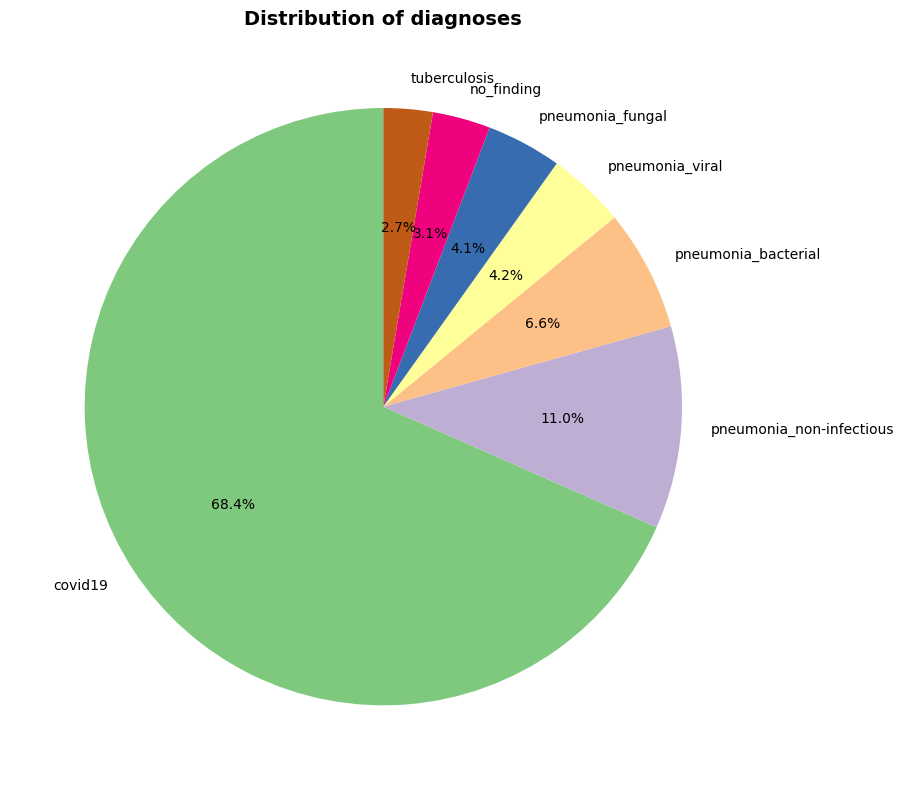

In [104]:
diagnoses_pdf = df_final.groupBy("diagnosis_unified").count().orderBy(col("count").desc()).toPandas()

plt.figure(figsize=(10, 8))
plt.pie(
    diagnoses_pdf["count"],
    labels=diagnoses_pdf["diagnosis_unified"],
    autopct="%1.1f%%",
    startangle=90,
    colors=plt.cm.Accent(range(len(diagnoses_pdf))),
    textprops={'fontsize': 10}
)
plt.title('Distribution of diagnoses', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### Столбчатая диаграмма по возрастным группам

In [78]:
age_pdf = df_final.groupBy("age_category").count().toPandas()
# Сортируем возрастные группы по порядку
age_order = ['youth (0-17)',
             'adults (18-35)',
             'mature (36-55)',
             'seniors (56-70)',
             'elderly (71+)']
age_pdf['sort_key'] = age_pdf['age_category'].apply(lambda x: age_order.index(x) if x in age_order else len(age_order))
age_pdf = age_pdf.sort_values('sort_key')

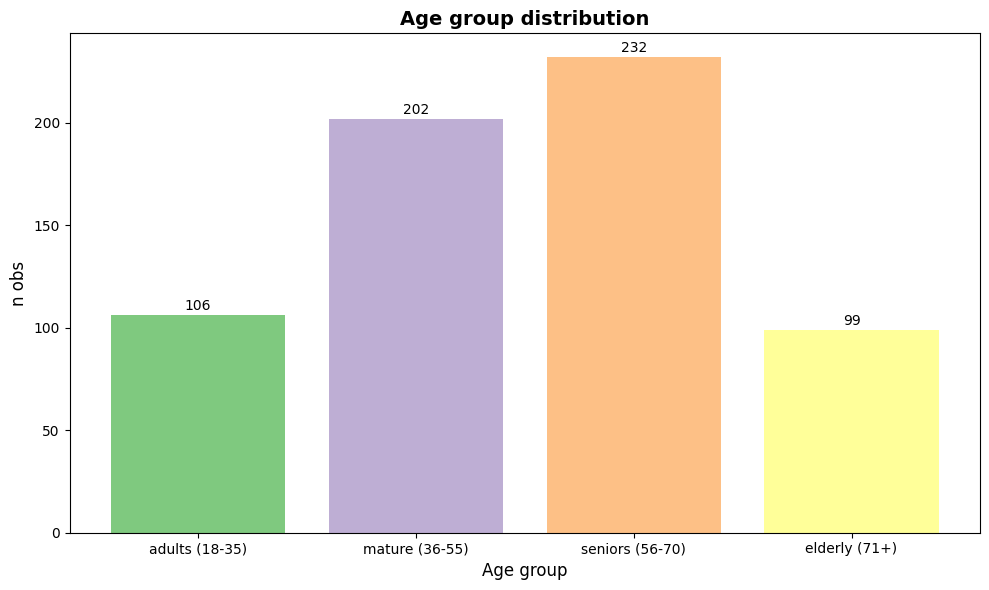

In [88]:
plt.figure(figsize=(10, 6))
bars = plt.bar(
    age_pdf['age_category'],
    age_pdf['count'],
    color=plt.cm.Accent(range(len(age_pdf)))
)
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        str(int(bar.get_height())),
        ha='center', va='bottom'
    )
plt.title('Age group distribution', fontsize=14, fontweight='bold')
plt.xlabel('Age group', fontsize=12)
plt.ylabel('n obs', fontsize=12)
plt.tight_layout()
plt.show()

Наибольшая частотность наблюдается у группы 56-70 лет. Обычно эта группа не является самой частотной в демографической пирамиде, поэтому можно с достаточно высокой вероятностью сказать, что легочные заболевания действительно более характерны для этой возрастной группы

Группа 71+ может быть слабо представлена в этой выборке ввиду своей численности (обычно демографическая пирамида сужается к верху, особенно, если речь не о странах с большим количеством возрастного населения, вроде Японии), поэтому более низкая численность относительно группы 56-70 может быть оправдана

#### График временных трендов исследований

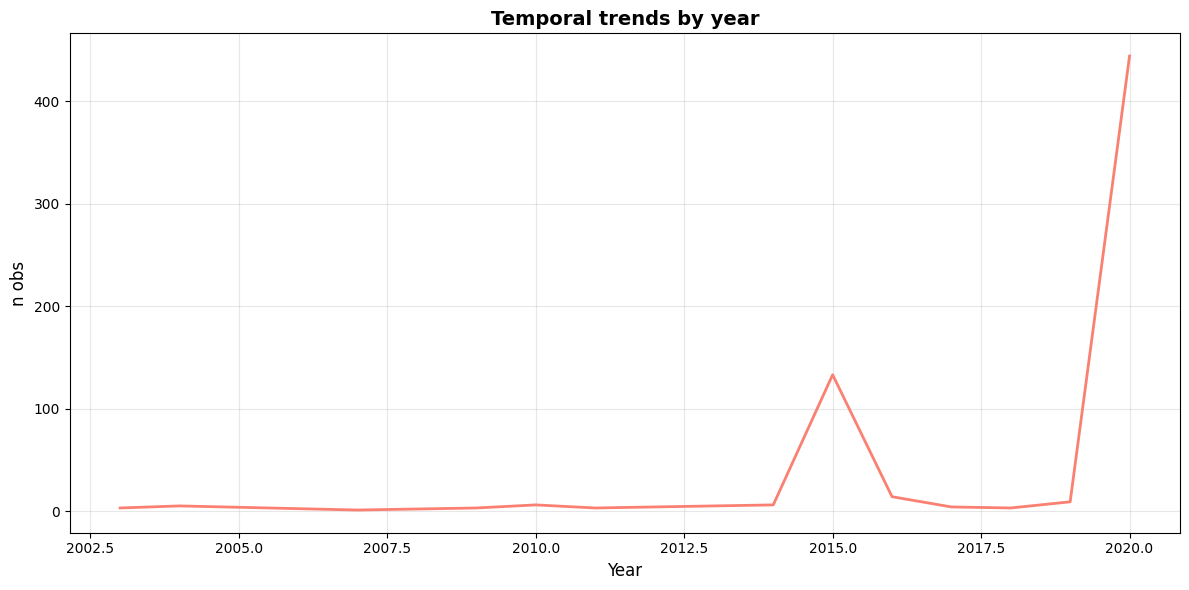

In [102]:
time_pdf = df_final.groupBy(year("date").alias("year")).count().orderBy("year").toPandas()

plt.figure(figsize=(12, 6))
plt.plot(time_pdf['year'], time_pdf['count'], color='salmon', linewidth=2)

plt.title('Temporal trends by year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('n obs', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Heatmap распределения диагнозов по проекциям снимков

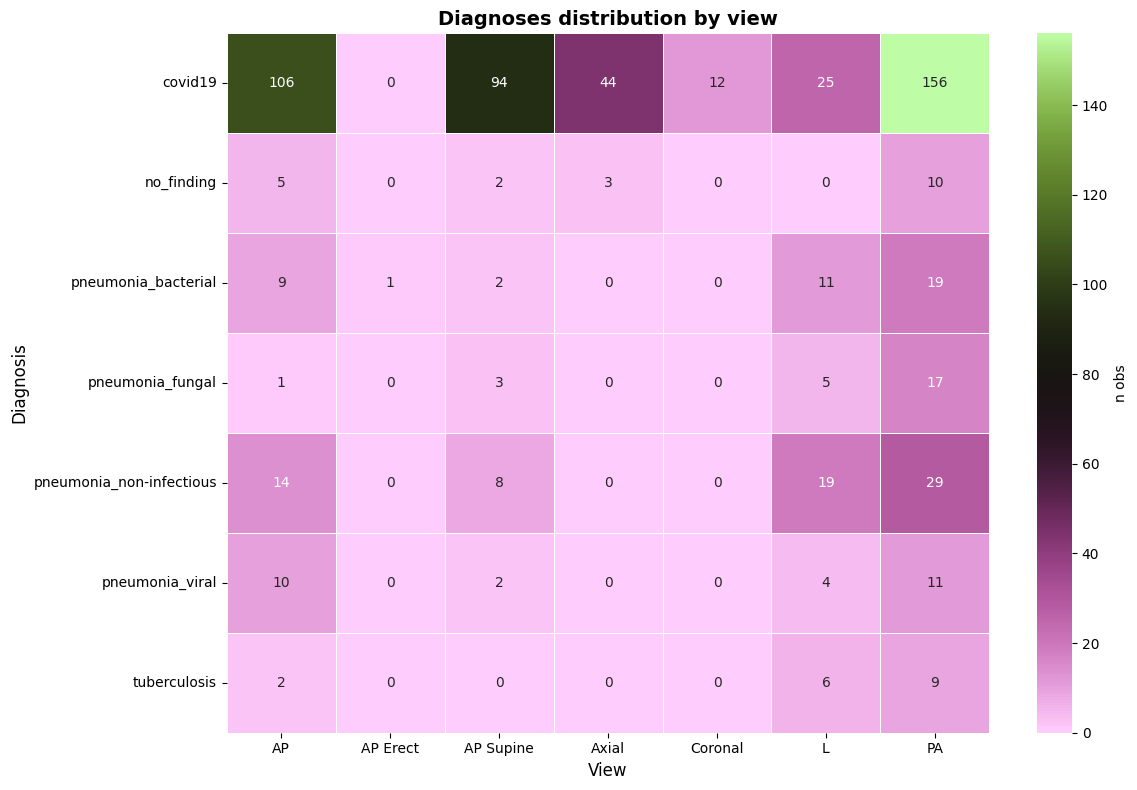

In [86]:
heatmap_pdf = df_final.groupBy("diagnosis_unified", "view").count().toPandas()
heatmap_pivot = heatmap_pdf.pivot(index="diagnosis_unified", columns="view", values="count").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_pivot,
    annot=True,
    fmt="g",
    cmap="vanimo",
    linewidths=0.5,
    linecolor='white',
    annot_kws={"fontsize": 10},
    cbar_kws={'label': 'n obs'}
)
plt.title('Diagnoses distribution by view', fontsize=14, fontweight='bold')
plt.xlabel('View', fontsize=12)
plt.ylabel('Diagnosis', fontsize=12)
plt.tight_layout()
plt.show()

Больше всего снимков делается в проекции PA, вне зависимости от болезни. Но для covid19 их было сделано больше всего

Как и ранее, отметим, что для covid19 наиболее характерны снимки в проекции PA, AP и AP Supine, каждый из которых составляет 25-34% от общего числа снимков, что может говорить о том, что для диагностики covid19 необходимо делать именно эти 3 снимка

С учётом того, что даже в категории 'no_finding' лидируют снимки типа PA, можно сделать предположение, что пациентов с подозрением на легочные заболевания в первую очередь отправляют на этот тип снимка. Этим может объясняться его частота. А после выявления некой паталогии направляют на более специфичные AP и AP Supine (в случае covid19)

Для других заболеваний характерны снимки в других проекциях: так, для бактериальной пневмонии важны снимки в проекции L

Также, снимок AP Erect практически не используется для диагностики перечисленных заболеваний